<a href="https://colab.research.google.com/github/Murarin8877/FinancialBigDataAnalysis-homework/blob/main/week9%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM%E3%80%81Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

[*********************100%***********************]  1 of 1 completed


Epoch 1/10, Loss: 0.1975
Epoch 2/10, Loss: 0.0614
Epoch 3/10, Loss: 0.0439
Epoch 4/10, Loss: 0.0254
Epoch 5/10, Loss: 0.0085
Epoch 6/10, Loss: 0.0065
Epoch 7/10, Loss: 0.0049
Epoch 8/10, Loss: 0.0037
Epoch 9/10, Loss: 0.0031
Epoch 10/10, Loss: 0.0024


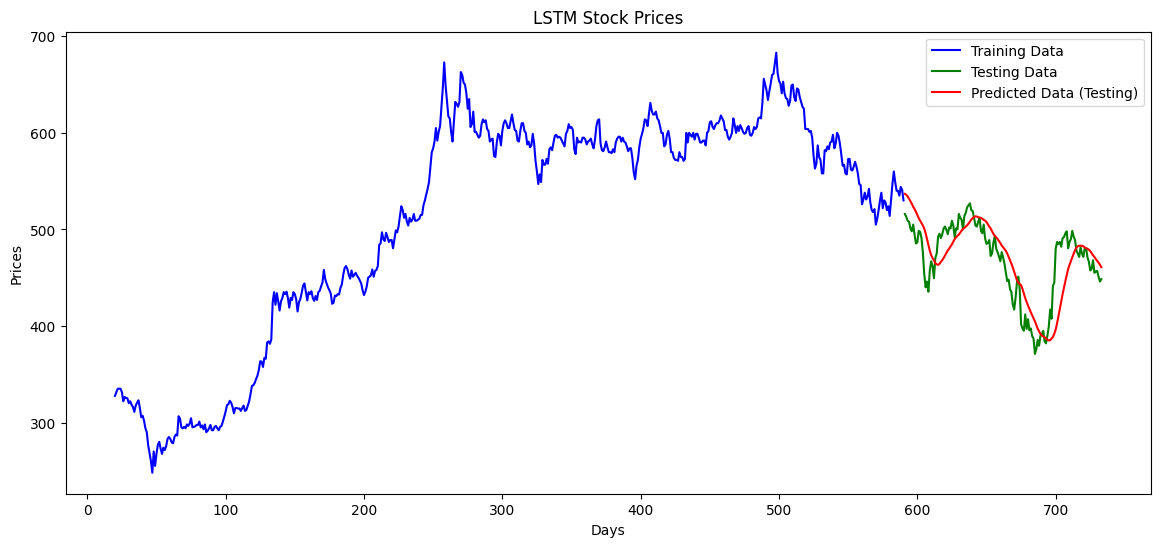

In [1]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 下載股票資料 (2330.TW)
data = yf.download('2330.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)

# 標準化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        _, (hn, _) = self.lstm(x, (h_0, c_0))
        out = self.linear(hn[-1])
        return out

# 初始化模型、損失函數和優化器
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 LSTM 模型
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(range(seq_length, seq_length + len(train_y_actual)), train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_y_actual)), test_y_actual,
         label='Testing Data', color='green')

# 繪製訓練集預測數據
#plt.plot(range(seq_length, seq_length + len(train_predictions)), train_predictions, label='Predicted Data (Training)', color='red', alpha=0.6)

# 繪製測試集預測數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_predictions)), test_predictions,
         label='Predicted Data (Testing)', color='red')

# 標題和標籤
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

#作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.2073
Epoch 2/10, Loss: 0.0267
Epoch 3/10, Loss: 0.0090
Epoch 4/10, Loss: 0.0072
Epoch 5/10, Loss: 0.0064
Epoch 6/10, Loss: 0.0056
Epoch 7/10, Loss: 0.0056
Epoch 8/10, Loss: 0.0045
Epoch 9/10, Loss: 0.0040
Epoch 10/10, Loss: 0.0040


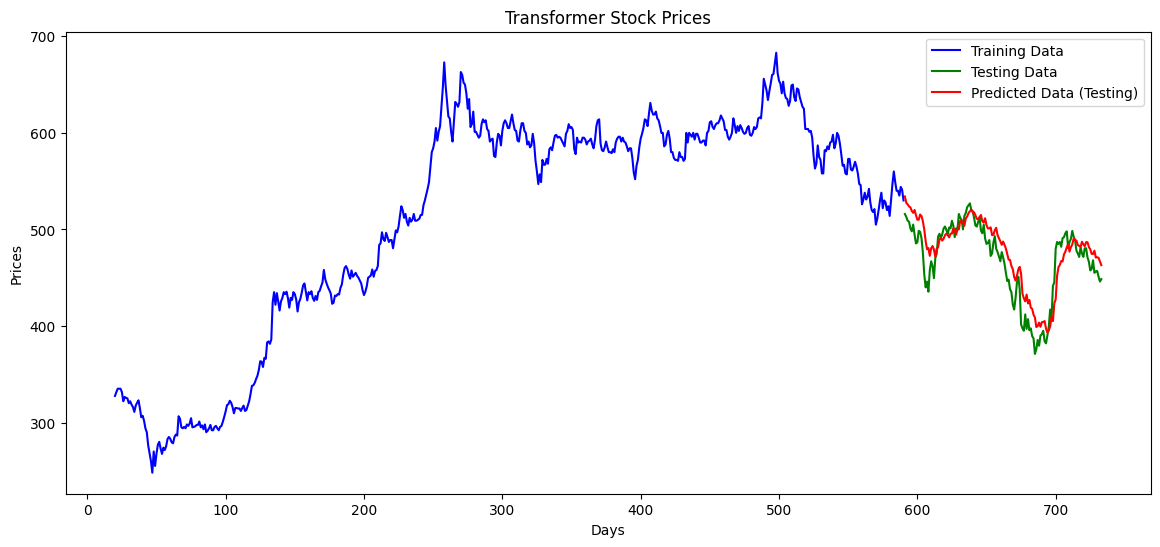

In [2]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 下載股票資料 (2330.TW)
data = yf.download('2330.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)

# 標準化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定義 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, output_size=1):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # 添加位置編碼
        x = self.input_layer(x) + self.positional_encoding
        x = self.transformer(x.permute(1, 0, 2))  # 需要調整為(seq_len, batch_size, d_model)
        return self.fc(x[-1])  # 取最後一個時間步的輸出

# 初始化模型、損失函數和優化器
model = TransformerModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 Transformer 模型
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(range(seq_length, seq_length + len(train_y_actual)), train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_y_actual)), test_y_actual,
         label='Testing Data', color='green')

# 繪製測試集預測數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_predictions)), test_predictions,
         label='Predicted Data (Testing)', color='red')

# 標題和標籤
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()